In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
f=pd.read_csv("20_years_data.csv")
df=pd.DataFrame(f,index = [x for x in range (0,f.shape[0])])
df = df[np.isfinite(df['PX_CLOSE_1D'])]
df=df.drop("BEST_DIV_YLD",axis=1)
df=pd.DataFrame(df,index = [x for x in range (0,df.shape[0])])
df=df.dropna(how='any')
new_index=[x for x in range (0,len(df))]
df['index']=df.index
print (df.isnull().sum())

Date                    0
PX_LOW                  0
PX_HIGH                 0
PX_VOLUME               0
PX_OPEN                 0
PX_CLOSE_1D             0
BEST_PE_RATIO           0
CUR_MKT_CAP             0
BETA_ADJ_OVERRIDABLE    0
index                   0
dtype: int64


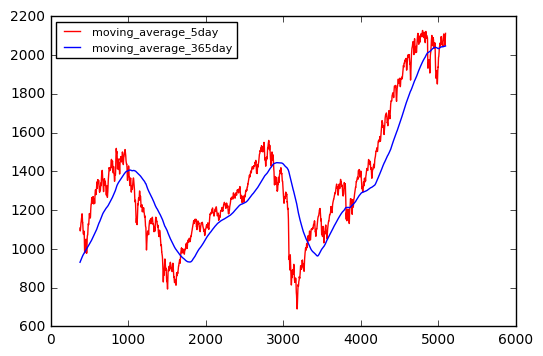

In [2]:
data_mean_5day=df['PX_OPEN'].rolling(window=5,center=False).mean()
data_mean_365day=df['PX_OPEN'].rolling(window=365,center=False).mean()
data_used_for_comparsion_365=data_mean_365day[365:len(data_mean_365day)]
data_used_for_comparsion_5=data_mean_5day[365:len(data_mean_5day)]
plt.plot(df['index'][365:len(data_mean_365day)],data_used_for_comparsion_5,c='red')
plt.plot(df['index'][365:len(data_mean_365day)],data_used_for_comparsion_365,c='blue')
plt.legend(['moving_average_5day','moving_average_365day'],loc=2,prop={'size':8})
plt.show()

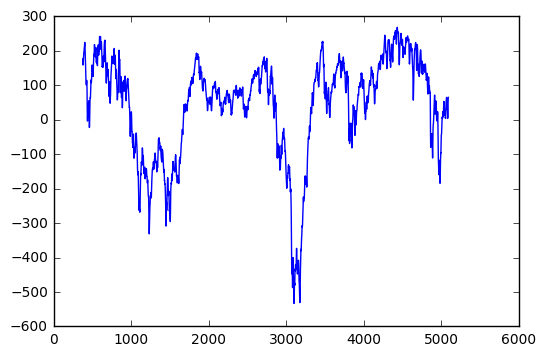

In [3]:
spread_between_5day_and_365day=data_used_for_comparsion_5-data_used_for_comparsion_365
plt.plot(spread_between_5day_and_365day.index,spread_between_5day_and_365day)
plt.show()
timespot=[x for x in spread_between_5day_and_365day.index if spread_between_5day_and_365day.loc[x]<=10 and spread_between_5day_and_365day.loc[x]>=-10]
potential_trading_chance=spread_between_5day_and_365day[timespot]
    

## Trend: Hodrick-Prescott filter

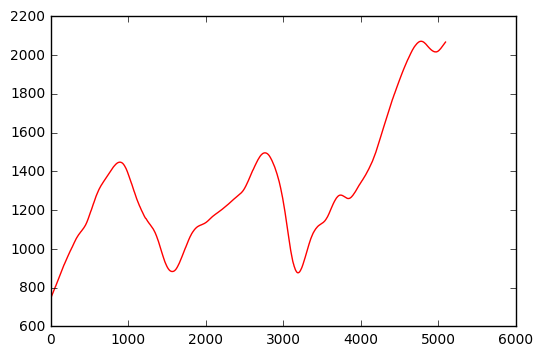

['Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Uptrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtrend', 'Downtren

In [108]:
import statsmodels.api as sm
PX_OPEN=df['PX_OPEN']

cycle,trend=sm.tsa.filters.hpfilter(PX_OPEN,lamb=12960000)
plt.plot(df['index'],trend,c='red')
plt.show()
trend_array=trend.as_matrix()
signal_trend=['Notrend']
signal=[0]
for k in range (1,len(trend_array)):
    if trend_array[k]-trend_array[k-1]<0:
        signal_trend.append('Downtrend')
    elif trend_array[k]-trend_array[k-1]>0:
        signal_trend.append('Uptrend')
    else:
        signal_trend.append('Notrend')
for i1 in range (1,len(signal_trend)):
    if signal_trend[i1]=='Downtrend' and signal_trend[i1-1]!='Downtrend':
        signal.append(-1)
    elif signal_trend[i1]=='Uptrend' and signal_trend[i1-1]!='Uptrend':
        signal.append(1)
    elif signal_trend[i1]!=signal_trend[i1-1]:
        signal.append(0)
print (signal_trend[800:1000])
print (signal[800:1000])
       


## Moving Average Indicator 

In [87]:
def sma(series, window=50, min_periods=0):
    # Center must always be False to circumvent look-ahead bias
    sma = series.rolling(window=window, min_periods=min_periods,
                         center=False).mean()
    sma.rename(index='SMA', inplace=True)
    return sma


def ema(series, window=50, min_periods=0):
    ema = series.ewm(span=window, min_periods=min_periods, adjust=False).mean()
    ema.rename(index='EMA', inplace=True)
    return ema


def macd(series, fast_window=12, slow_window=26, signal_window=9):
    dema = ema(series, window=fast_window) - ema(series, window=slow_window)
    dema_matrix=dema.as_matrix()
    signal=[0]
    for i in range (1,len(dema_matrix)):
        if dema_matrix[i]<0 and dema_matrix[i-1]/dema_matrix[i]<=0:
            signal.append(1)
        elif dema_matrix[i]>0 and dema_matrix[i-1]/dema_matrix[i]<=0:
            signal.append(-1)
        elif dema_matrix[i-1]/dema_matrix[i]>0:
            signal.append(0)
    unique, counts=np.unique(signal,return_counts=True)
    df['Signal_MACD']=signal
    return (np.asarray((unique, counts)).T)

    
macd(df['PX_CLOSE_1D'],20,50)

array([[  -1,   45],
       [   0, 4824],
       [   1,   45]])